# rule based feature 추출

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
# import Project_LG_Welding_AD.src.extract_rule_based_features as extract_rule_based_features
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter
import os
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter


%matplotlib inline

wd = Path.cwd()
data_path = wd.parent / 'data'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Anode

In [2]:
wd

PosixPath('/workspace/LG_sangiwon')

In [3]:
data_path

PosixPath('/workspace/data')

In [4]:
data_path = '/workspace/LG_sangiwon/data/'

In [10]:
Anode_Normal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Normal")).glob("*.csv")])
Anode_Normal = sorted(Anode_Normal)

Anode_Abnormal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Abnormal")).glob("*.csv")])
Anode_Abnormal = sorted(Anode_Abnormal)
len(Anode_Normal), len(Anode_Abnormal)

(35, 18)

In [6]:
# data = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/20230412_110032_0__03_Total.csv"))
# len(data)

# data2 = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/31.csv"))
# len(data2)

In [11]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

### Dataset별 bead detection 후 time series concat

In [13]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [14]:
Cathode_Normal = sorted([x for x in Path(os.path.join(data_path, "230507/Cathode/Normal")).glob("*.csv")])
Cathode_Normal = sorted(Cathode_Normal)

Cathode_Abnormal = sorted([x for x in Path(os.path.join(data_path, "230507/Cathode/Abnormal")).glob("*.csv")])
Cathode_Abnormal = sorted(Cathode_Abnormal)

In [15]:
len(Cathode_Normal), len(Cathode_Abnormal)

(31, 17)

In [16]:
data_folder_list = Cathode_Normal + Cathode_Abnormal
num_train_dataset = 24
Cathode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Cathode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Train = pd.concat([Cathode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Cathode_Test = pd.concat([Cathode_Test, bead_i])

warning index: 59479
error index: 59578
warning index: 60128
error index: 60227
warning index: 60777
error index: 60876
warning index: 61427
error index: 61526
warning index: 62076
error index: 62175
warning index: 62725
error index: 62824
warning index: 63374
error index: 63473
warning index: 64022
error index: 64121
warning index: 64671
error index: 64770
warning index: 65321
error index: 65420
warning index: 65970
error index: 66069
warning index: 66619
error index: 66718
warning index: 67268
error index: 67367
warning index: 67917
error index: 68016
warning index: 68567
error index: 68666
warning index: 69216
error index: 69315
warning index: 69865
error index: 69964
warning index: 70514
error index: 70613
warning index: 71163
error index: 71262
warning index: 71813
error index: 71912
warning index: 72462
error index: 72561
warning index: 73111
error index: 73210
warning index: 73760
error index: 73859
warning index: 74409
error index: 74508
warning index: 75058
error index: 75157


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 37684
error index: 37783
warning index: 38334
error index: 38433
warning index: 38983
error index: 39082
warning index: 39632
error index: 39731
warning index: 40281
error index: 40380
warning index: 40930
error index: 41029
warning index: 41580
error index: 41679
warning index: 42230
error index: 42329
warning index: 42879
error index: 42978
warning index: 43529
error index: 43628
warning index: 44178
error index: 44277
warning index: 44828
error index: 44927
warning index: 45477
error index: 45576
warning index: 46126
error index: 46225
warning index: 46776
error index: 46875
warning index: 47425
error index: 47524
warning index: 48074
error index: 48173
warning index: 48723
error index: 48822
warning index: 49372
error index: 49471
warning index: 50021
error index: 50120
warning index: 50671
error index: 50770
warning index: 51320
error index: 51419
warning index: 51970
error index: 52069
warning index: 52619
error index: 52718
warning index: 53269
error index: 53368


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44061
error index: 44160
warning index: 44711
error index: 44810
warning index: 45360
error index: 45459
warning index: 46009
error index: 46108
warning index: 46658
error index: 46757
warning index: 47307
error index: 47406
warning index: 47957
error index: 48056
warning index: 48607
error index: 48706
warning index: 49256
error index: 49355
warning index: 49906
error index: 50005
warning index: 50555
error index: 50654
warning index: 51205
error index: 51304
warning index: 51854
error index: 51953
warning index: 52503
error index: 52602
warning index: 53153
error index: 53252
warning index: 53802
error index: 53901
warning index: 54451
error index: 54550
warning index: 55100
error index: 55199
warning index: 55749
error index: 55848
warning index: 56398
error index: 56497
warning index: 57048
error index: 57147
warning index: 57697
error index: 57796
warning index: 58347
error index: 58446
warning index: 58996
error index: 59095
warning index: 59646
error index: 59745


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 42022
error index: 42121
warning index: 42672
error index: 42771
warning index: 43321
error index: 43420
warning index: 43970
error index: 44069
warning index: 44619
error index: 44718
warning index: 45268
error index: 45367
warning index: 45918
error index: 46017
warning index: 46568
error index: 46667
warning index: 47217
error index: 47316
warning index: 47867
error index: 47966
warning index: 48516
error index: 48615
warning index: 49166
error index: 49265
warning index: 49815
error index: 49914
warning index: 50464
error index: 50563
warning index: 51114
error index: 51213
warning index: 51763
error index: 51862
warning index: 52412
error index: 52511
warning index: 53061
error index: 53160
warning index: 53710
error index: 53809
warning index: 54359
error index: 54458
warning index: 55009
error index: 55108
warning index: 55658
error index: 55757
warning index: 56308
error index: 56407
warning index: 56957
error index: 57056
warning index: 57607
error index: 57706


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39144
warning index: 39145
error index: 39243
warning index: 39794
error index: 39893
warning index: 40443
error index: 40542
warning index: 41092
error index: 41191
warning index: 41741
error index: 41840
warning index: 42390
warning index: 42391
error index: 42489
warning index: 43040
warning index: 43041
error index: 43139
warning index: 43690
warning index: 43691
error index: 43789
warning index: 44339
error index: 44438
warning index: 44989
error index: 45088
warning index: 45638
warning index: 45639
error index: 45737
warning index: 46288
error index: 46387
warning index: 46937
error index: 47036
warning index: 47586
error index: 47685
warning index: 48236
error index: 48335
warning index: 48885
error index: 48984
warning index: 49534
error index: 49633
warning index: 50183
error index: 50282
warning index: 50832
error index: 50931
warning index: 51481
error index: 51580
warning index: 52131
error index: 52230
warning index: 52780
error index: 52879
warning index: 

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 42515
error index: 42614
warning index: 43165
error index: 43264
warning index: 43814
error index: 43913
warning index: 44463
error index: 44562
warning index: 45112
error index: 45211
warning index: 45761
error index: 45860
warning index: 46411
error index: 46510
warning index: 47061
error index: 47160
warning index: 47710
error index: 47809
warning index: 48360
error index: 48459
warning index: 49009
error index: 49108
warning index: 49659
error index: 49758
warning index: 50308
error index: 50407
warning index: 50957
error index: 51056
warning index: 51607
error index: 51706
warning index: 52256
error index: 52355
warning index: 52905
error index: 53004
warning index: 53554
error index: 53653
warning index: 54203
error index: 54302
warning index: 54852
error index: 54951
warning index: 55502
error index: 55601
warning index: 56151
error index: 56250
warning index: 56801
error index: 56900
warning index: 57450
error index: 57549
warning index: 58100
error index: 58199


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 51316
error index: 51415
warning index: 51966
error index: 52065
warning index: 52615
error index: 52714
warning index: 53264
error index: 53363
warning index: 53913
error index: 54012
warning index: 54562
error index: 54661
warning index: 55212
error index: 55311
warning index: 55862
error index: 55961
warning index: 56511
error index: 56610
warning index: 57161
error index: 57260
warning index: 57810
error index: 57909
warning index: 58460
error index: 58559
warning index: 59109
error index: 59208
warning index: 59758
error index: 59857
warning index: 60408
error index: 60507
warning index: 61057
error index: 61156
warning index: 61706
error index: 61805
warning index: 62355
error index: 62454
warning index: 63004
error index: 63103
warning index: 63653
error index: 63752
warning index: 64303
error index: 64402
warning index: 64952
error index: 65051
warning index: 65602
error index: 65701
warning index: 66251
error index: 66350
warning index: 66901
error index: 67000


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 37419
error index: 37518
warning index: 38069
error index: 38168
warning index: 38718
error index: 38817
error index: 38818
warning index: 39367
error index: 39466
warning index: 40016
error index: 40115
warning index: 40665
error index: 40764
warning index: 41315
error index: 41414
warning index: 41965
error index: 42064
warning index: 42614
error index: 42713
warning index: 43264
error index: 43363
warning index: 43913
error index: 44012
warning index: 44563
error index: 44662
warning index: 45212
error index: 45311
warning index: 45861
error index: 45960
warning index: 46511
error index: 46610
warning index: 47160
error index: 47259
warning index: 47809
error index: 47908
warning index: 48458
error index: 48557
warning index: 49107
error index: 49206
warning index: 49756
error index: 49855
warning index: 50406
error index: 50505
warning index: 51055
error index: 51154
warning index: 51705
error index: 51804
warning index: 52354
error index: 52453
warning index: 53004


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 35373
error index: 35472
warning index: 36023
error index: 36122
warning index: 36672
error index: 36771
warning index: 37321
error index: 37420
warning index: 37970
error index: 38069
warning index: 38619
error index: 38718
warning index: 39269
error index: 39368
warning index: 39919
error index: 40018
warning index: 40568
error index: 40667
warning index: 41218
error index: 41317
warning index: 41867
error index: 41966
warning index: 42517
error index: 42616
warning index: 43166
error index: 43265
warning index: 43815
error index: 43914
warning index: 44466
error index: 44564
warning index: 45114
error index: 45213
warning index: 45763
error index: 45862
warning index: 46412
error index: 46511
warning index: 47061
error index: 47160
warning index: 47710
error index: 47809
warning index: 48360
error index: 48459
warning index: 49009
error index: 49108
warning index: 49659
error index: 49758
warning index: 50308
error index: 50407
warning index: 50958
error index: 51057


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 42375
error index: 42474
warning index: 43025
error index: 43124
warning index: 43674
error index: 43773
warning index: 44323
error index: 44422
warning index: 44972
error index: 45071
warning index: 45621
error index: 45720
warning index: 46271
error index: 46370
warning index: 46921
error index: 47020
warning index: 47570
error index: 47669
warning index: 48220
error index: 48319
warning index: 48869
error index: 48968
warning index: 49519
error index: 49618
warning index: 50168
error index: 50267
warning index: 50817
error index: 50916
warning index: 51467
error index: 51566
warning index: 52116
error index: 52215
warning index: 52765
error index: 52864
warning index: 53414
error index: 53513
warning index: 54063
error index: 54162
warning index: 54712
error index: 54811
warning index: 55362
error index: 55461
warning index: 56011
error index: 56110
warning index: 56661
error index: 56760
warning index: 57310
error index: 57409
warning index: 57960
error index: 58059


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39185
error index: 39284
warning index: 39835
error index: 39934
warning index: 40484
error index: 40583
warning index: 41133
error index: 41232
warning index: 41782
error index: 41881
warning index: 42431
error index: 42530
warning index: 43081
error index: 43180
warning index: 43731
error index: 43830
warning index: 44380
error index: 44479
warning index: 45030
error index: 45129
warning index: 45679
error index: 45778
warning index: 46329
error index: 46428
warning index: 46978
error index: 47077
warning index: 47627
error index: 47726
warning index: 48277
error index: 48376
warning index: 48926
error index: 49025
warning index: 49575
error index: 49674
warning index: 50224
error index: 50323
warning index: 50873
error index: 50972
warning index: 51522
error index: 51621
warning index: 52172
error index: 52271
warning index: 52821
error index: 52920
warning index: 53471
error index: 53570
warning index: 54120
error index: 54219
warning index: 54770
error index: 54869


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47761
error index: 47860
warning index: 48411
error index: 48510
warning index: 49060
error index: 49159
warning index: 49709
error index: 49808
warning index: 50358
error index: 50457
warning index: 51007
error index: 51106
warning index: 51657
error index: 51756
warning index: 52307
error index: 52406
warning index: 52956
error index: 53055
warning index: 53606
error index: 53705
warning index: 54255
error index: 54354
warning index: 54905
error index: 55004
warning index: 55554
error index: 55653
warning index: 56203
error index: 56302
warning index: 56853
error index: 56952
warning index: 57502
error index: 57601
warning index: 58151
error index: 58250
warning index: 58800
error index: 58899
warning index: 59449
error index: 59548
warning index: 60098
error index: 60197
warning index: 60748
error index: 60847
warning index: 61397
error index: 61496
warning index: 62047
error index: 62146
warning index: 62696
error index: 62795
warning index: 63346
error index: 63445


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40182
error index: 40280
warning index: 40831
warning index: 40832
error index: 40930
warning index: 41480
warning index: 41481
error index: 41579
warning index: 42130
error index: 42228
warning index: 42779
error index: 42877
warning index: 43427
error index: 43526
warning index: 44077
error index: 44176
warning index: 44727
error index: 44826
warning index: 45376
error index: 45475
warning index: 46026
error index: 46125
warning index: 46675
error index: 46774
warning index: 47325
error index: 47424
warning index: 47974
error index: 48073
warning index: 48623
error index: 48722
warning index: 49273
error index: 49372
warning index: 49922
error index: 50021
warning index: 50571
error index: 50670
warning index: 51220
error index: 51319
warning index: 51869
error index: 51968
warning index: 52518
error index: 52617
warning index: 53168
error index: 53267
warning index: 53817
error index: 53916
warning index: 54467
error index: 54566
warning index: 55116
error index: 5521

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39844
error index: 39943
warning index: 40494
error index: 40593
warning index: 41143
error index: 41242
warning index: 41792
error index: 41891
warning index: 42441
error index: 42540
warning index: 43090
error index: 43189
warning index: 43740
error index: 43839
warning index: 44390
error index: 44489
warning index: 45039
error index: 45138
warning index: 45689
error index: 45788
warning index: 46338
error index: 46437
warning index: 46988
error index: 47087
warning index: 47637
error index: 47736
warning index: 48286
error index: 48385
warning index: 48936
error index: 49035
warning index: 49585
error index: 49684
warning index: 50234
error index: 50333
warning index: 50882
warning index: 50883
error index: 50981
warning index: 51531
warning index: 51532
error index: 51630
warning index: 52180
warning index: 52181
error index: 52279
warning index: 52830
warning index: 52831
error index: 52929
warning index: 53479
warning index: 53480
error index: 53578
warning index: 

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 43459
error index: 43558
warning index: 44109
error index: 44208
warning index: 44758
error index: 44857
warning index: 45407
error index: 45506
warning index: 46056
error index: 46155
warning index: 46705
error index: 46804
warning index: 47354
warning index: 47355
error index: 47454
warning index: 48004
warning index: 48005
error index: 48104
warning index: 48654
error index: 48753
warning index: 49304
error index: 49403
warning index: 49952
warning index: 49953
error index: 50052
warning index: 50603
error index: 50702
warning index: 51251
warning index: 51252
error index: 51351
warning index: 51900
warning index: 51901
error index: 52000
warning index: 52550
warning index: 52551
error index: 52650
warning index: 53199
warning index: 53200
error index: 53299
warning index: 53848
warning index: 53849
error index: 53948
warning index: 54497
warning index: 54498
error index: 54597
warning index: 55146
warning index: 55147
error index: 55246
warning index: 55795
warning i

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 49652
error index: 49751
warning index: 50302
error index: 50401
warning index: 50951
error index: 51050
warning index: 51600
error index: 51699
warning index: 52249
error index: 52348
warning index: 52898
error index: 52997
warning index: 53548
error index: 53647
warning index: 54198
error index: 54297
warning index: 54847
error index: 54946
warning index: 55497
error index: 55596
warning index: 56146
error index: 56245
warning index: 56796
error index: 56895
warning index: 57445
error index: 57544
warning index: 58094
error index: 58193
warning index: 58744
error index: 58843
warning index: 59393
error index: 59492
warning index: 60042
error index: 60141
warning index: 60691
error index: 60790
warning index: 61340
error index: 61439
warning index: 61989
error index: 62088
warning index: 62639
error index: 62738
warning index: 63288
error index: 63387
warning index: 63938
error index: 64037
warning index: 64587
error index: 64686
warning index: 65237
error index: 65336


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 36887
error index: 36986
warning index: 37537
error index: 37636
warning index: 38186
error index: 38285
warning index: 38835
error index: 38934
warning index: 39484
error index: 39583
warning index: 40133
error index: 40232
warning index: 40783
error index: 40882
warning index: 41433
error index: 41532
warning index: 42082
error index: 42181
warning index: 42732
error index: 42831
warning index: 43381
error index: 43480
warning index: 44031
error index: 44130
warning index: 44680
error index: 44779
warning index: 45329
error index: 45428
warning index: 45979
error index: 46078
warning index: 46628
error index: 46727
warning index: 47277
error index: 47376
warning index: 47926
error index: 48025
warning index: 48575
error index: 48674
warning index: 49224
error index: 49323
warning index: 49874
error index: 49973
warning index: 50523
error index: 50622
warning index: 51173
error index: 51272
warning index: 51822
error index: 51921
warning index: 52472
error index: 52571


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40100
error index: 40199
warning index: 40750
error index: 40849
warning index: 41399
error index: 41498
warning index: 42048
error index: 42147
warning index: 42697
error index: 42796
warning index: 43346
error index: 43445
warning index: 43996
error index: 44095
warning index: 44646
warning index: 44647
error index: 44745
warning index: 45295
warning index: 45296
error index: 45394
warning index: 45945
error index: 46044
warning index: 46594
error index: 46693
warning index: 47244
error index: 47343
warning index: 47893
error index: 47992
warning index: 48542
error index: 48641
warning index: 49192
error index: 49291
warning index: 49841
error index: 49940
warning index: 50490
error index: 50589
warning index: 51139
error index: 51238
warning index: 51788
error index: 51887
warning index: 52437
error index: 52536
warning index: 53087
error index: 53186
warning index: 53736
error index: 53835
warning index: 54386
error index: 54485
warning index: 55035
error index: 5513

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 40061
error index: 40160
warning index: 40711
error index: 40810
warning index: 41360
error index: 41459
warning index: 42009
error index: 42108
warning index: 42658
error index: 42757
warning index: 43307
error index: 43406
warning index: 43957
error index: 44056
warning index: 44607
error index: 44706
warning index: 45256
error index: 45355
warning index: 45906
error index: 46005
warning index: 46555
error index: 46654
warning index: 47205
error index: 47304
warning index: 47854
error index: 47953
warning index: 48503
error index: 48602
warning index: 49153
error index: 49252
warning index: 49802
error index: 49901
warning index: 50451
error index: 50550
warning index: 51100
error index: 51199
warning index: 51749
error index: 51848
warning index: 52398
error index: 52497
warning index: 53048
error index: 53147
warning index: 53697
error index: 53796
warning index: 54347
error index: 54446
warning index: 54996
error index: 55095
warning index: 55646
error index: 55745


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 47028
error index: 47127
warning index: 47678
error index: 47777
warning index: 48327
error index: 48426
error index: 48427
warning index: 48976
error index: 49075
warning index: 49625
error index: 49724
warning index: 50274
error index: 50373
error index: 50374
warning index: 50924
error index: 51023
warning index: 51574
error index: 51673
warning index: 52223
error index: 52322
warning index: 52873
error index: 52971
error index: 52972
warning index: 53522
error index: 53620
error index: 53621
warning index: 54172
error index: 54270
warning index: 54821
error index: 54919
warning index: 55470
error index: 55568
warning index: 56120
error index: 56218
warning index: 56769
error index: 56867
warning index: 57418
error index: 57516
error index: 57517
warning index: 58067
error index: 58165
error index: 58166
warning index: 58716
error index: 58814
warning index: 59365
error index: 59463
warning index: 60015
error index: 60113
error index: 60114
warning index: 60663
warnin

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39697
warning index: 39698
error index: 39796
error index: 39797
warning index: 40347
error index: 40446
warning index: 40996
error index: 41095
warning index: 41645
error index: 41744
warning index: 42294
error index: 42393
warning index: 42943
error index: 43042
warning index: 43593
error index: 43692
warning index: 44243
error index: 44342
warning index: 44892
error index: 44991
warning index: 45542
error index: 45641
warning index: 46191
error index: 46290
warning index: 46841
error index: 46940
warning index: 47490
error index: 47589
warning index: 48139
error index: 48238
warning index: 48789
error index: 48888
warning index: 49438
error index: 49537
warning index: 50087
error index: 50186
warning index: 50736
error index: 50835
warning index: 51385
error index: 51484
warning index: 52034
error index: 52133
warning index: 52684
error index: 52783
warning index: 53333
error index: 53432
warning index: 53983
error index: 54082
warning index: 54632
error index: 54731


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 44775
error index: 44874
warning index: 45425
error index: 45524
warning index: 46074
error index: 46173
warning index: 46723
error index: 46822
warning index: 47372
error index: 47471
warning index: 48021
error index: 48120
warning index: 48671
error index: 48770
warning index: 49321
error index: 49420
warning index: 49970
error index: 50069
warning index: 50620
error index: 50719
warning index: 51269
error index: 51368
warning index: 51919
error index: 52018
warning index: 52567
error index: 52666
warning index: 53216
error index: 53315
warning index: 53866
error index: 53965
warning index: 54515
error index: 54614
warning index: 55164
error index: 55263
warning index: 55813
error index: 55912
warning index: 56462
error index: 56561
warning index: 57111
error index: 57210
warning index: 57761
error index: 57860
warning index: 58410
error index: 58509
warning index: 59060
error index: 59159
warning index: 59709
error index: 59808
warning index: 60359
error index: 60458


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39955
error index: 40054
warning index: 40605
error index: 40704
warning index: 41254
error index: 41353
warning index: 41903
error index: 42002
warning index: 42552
error index: 42651
warning index: 43201
error index: 43300
warning index: 43851
error index: 43950
warning index: 44501
error index: 44600
warning index: 45150
error index: 45249
warning index: 45800
error index: 45899
warning index: 46449
error index: 46548
warning index: 47099
error index: 47198
warning index: 47748
error index: 47847
warning index: 48397
error index: 48496
warning index: 49047
error index: 49146
warning index: 49696
error index: 49795
warning index: 50345
error index: 50444
warning index: 50994
error index: 51093
warning index: 51643
error index: 51742
warning index: 52292
error index: 52391
warning index: 52942
error index: 53041
warning index: 53591
error index: 53690
warning index: 54241
error index: 54340
warning index: 54890
error index: 54989
warning index: 55540
error index: 55639


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 50987
warning index: 50988
error index: 51087
warning index: 51637
warning index: 51638
error index: 51737
warning index: 52286
error index: 52386
warning index: 52935
warning index: 52936
error index: 53035
warning index: 53584
warning index: 53585
error index: 53684
warning index: 54233
error index: 54333
warning index: 54883
error index: 54983
warning index: 55533
warning index: 55534
error index: 55633
warning index: 56182
error index: 56282
warning index: 56832
warning index: 56833
error index: 56932
warning index: 57481
error index: 57581
warning index: 58131
error index: 58231
warning index: 58780
error index: 58880
warning index: 59429
error index: 59529
warning index: 60079
error index: 60179
warning index: 60728
error index: 60827
warning index: 61377
error index: 61476
warning index: 62026
error index: 62125
warning index: 62675
error index: 62774
warning index: 63324
error index: 63423
warning index: 63974
error index: 64073
warning index: 64623
error index: 

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45819
error index: 45918
warning index: 46469
error index: 46568
warning index: 47118
error index: 47217
warning index: 47767
error index: 47866
warning index: 48416
error index: 48515
warning index: 49065
error index: 49164
warning index: 49715
error index: 49814
warning index: 50365
error index: 50464
warning index: 51013
warning index: 51014
error index: 51113
warning index: 51663
error index: 51763
warning index: 52312
error index: 52411
error index: 52412
warning index: 52962
error index: 53062
warning index: 53611
error index: 53710
error index: 53711
warning index: 54260
error index: 54359
error index: 54360
warning index: 54910
error index: 55010
warning index: 55559
error index: 55659
warning index: 56208
error index: 56307
error index: 56308
warning index: 56857
error index: 56956
error index: 56957
warning index: 57506
error index: 57605
error index: 57606
warning index: 58155
error index: 58254
error index: 58255
warning index: 58805
error index: 58904
error 

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 38802
error index: 38901
error index: 38902
warning index: 39452
error index: 39551
error index: 39552
warning index: 40101
error index: 40200
error index: 40201
warning index: 40750
error index: 40849
warning index: 41399
error index: 41498
warning index: 42048
error index: 42147
error index: 42148
warning index: 42698
error index: 42797
warning index: 43350
error index: 43447
error index: 43448
warning index: 43997
error index: 44096
warning index: 44647
error index: 44746
warning index: 45296
error index: 45395
warning index: 45946
error index: 46045
warning index: 46595
error index: 46694
warning index: 47244
error index: 47343
error index: 47344
warning index: 47894
error index: 47993
warning index: 48543
error index: 48642
warning index: 49192
error index: 49291
warning index: 49841
error index: 49940
warning index: 50490
error index: 50589
warning index: 51139
error index: 51238
warning index: 51789
error index: 51888
warning index: 52438
error index: 52537
error 

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 45440
warning index: 45441
error index: 45540
warning index: 46090
warning index: 46091
error index: 46190
warning index: 46739
warning index: 46740
error index: 46838
warning index: 47388
error index: 47487
warning index: 48037
error index: 48136
warning index: 48686
error index: 48785
warning index: 49336
error index: 49435
warning index: 49986
error index: 50085
warning index: 50635
error index: 50734
warning index: 51285
error index: 51384
warning index: 51934
error index: 52033
warning index: 52584
error index: 52683
warning index: 53233
error index: 53332
warning index: 53882
error index: 53981
warning index: 54532
error index: 54631
warning index: 55181
error index: 55280
warning index: 55830
error index: 55929
warning index: 56479
error index: 56578
warning index: 57128
error index: 57227
warning index: 57777
error index: 57876
warning index: 58427
error index: 58526
warning index: 59076
error index: 59175
warning index: 59726
error index: 59825
warning index: 60

/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 39922
error index: 40021
warning index: 40572
error index: 40671
warning index: 41221
error index: 41320
warning index: 41870
error index: 41969
warning index: 42519
error index: 42618
warning index: 43168
error index: 43267
warning index: 43818
error index: 43917
warning index: 44468
error index: 44567
warning index: 45117
error index: 45216
warning index: 45767
error index: 45866
warning index: 46416
error index: 46515
warning index: 47066
error index: 47165
warning index: 47715
error index: 47814
warning index: 48364
error index: 48463
warning index: 49014
error index: 49113
warning index: 49663
error index: 49762
warning index: 50312
error index: 50411
warning index: 50961
error index: 51060
warning index: 51610
error index: 51709
warning index: 52259
error index: 52358
warning index: 52909
error index: 53008
warning index: 53558
error index: 53657
warning index: 54208
error index: 54307
warning index: 54857
error index: 54956
warning index: 55507
error index: 55606


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 49084
error index: 49183
warning index: 49734
error index: 49833
warning index: 50383
error index: 50482
warning index: 51032
error index: 51131
warning index: 51681
error index: 51780
warning index: 52330
error index: 52429
warning index: 52980
error index: 53079
warning index: 53630
error index: 53729
warning index: 54279
error index: 54378
warning index: 54929
error index: 55028
warning index: 55578
error index: 55677
warning index: 56228
error index: 56327
warning index: 56877
error index: 56976
warning index: 57526
error index: 57625
warning index: 58176
error index: 58275
warning index: 58825
error index: 58924
warning index: 59474
error index: 59573
warning index: 60123
error index: 60222
warning index: 60772
error index: 60871
warning index: 61421
error index: 61520
warning index: 62071
error index: 62170
warning index: 62720
error index: 62819
warning index: 63370
error index: 63469
warning index: 64019
error index: 64118
warning index: 64669
error index: 64768


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 41023
error index: 41122
warning index: 41673
error index: 41772
warning index: 42322
error index: 42421
warning index: 42971
error index: 43070
warning index: 43620
error index: 43719
warning index: 44269
error index: 44368
warning index: 44919
error index: 45018
warning index: 45569
error index: 45668
warning index: 46218
error index: 46317
warning index: 46868
error index: 46967
warning index: 47517
error index: 47616
warning index: 48167
error index: 48266
warning index: 48816
error index: 48915
warning index: 49465
error index: 49564
warning index: 50115
error index: 50214
warning index: 50764
error index: 50863
warning index: 51412
error index: 51512
warning index: 52062
error index: 52161
warning index: 52711
error index: 52810
warning index: 53360
error index: 53459
warning index: 54010
error index: 54109
warning index: 54659
error index: 54758
warning index: 55309
error index: 55408
warning index: 55958
error index: 56057
warning index: 56608
error index: 56707


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 37261
error index: 37360
warning index: 37911
error index: 38010
warning index: 38560
error index: 38659
warning index: 39209
error index: 39308
warning index: 39858
error index: 39957
warning index: 40507
error index: 40606
warning index: 41157
error index: 41256
warning index: 41807
error index: 41906
warning index: 42456
error index: 42555
warning index: 43106
error index: 43205
warning index: 43755
error index: 43854
warning index: 44405
error index: 44504
warning index: 45054
error index: 45153
warning index: 45703
error index: 45802
warning index: 46353
error index: 46452
warning index: 47002
error index: 47101
warning index: 47651
error index: 47750
warning index: 48300
error index: 48399
warning index: 48949
error index: 49048
warning index: 49598
error index: 49697
warning index: 50248
error index: 50347
warning index: 50897
error index: 50996
warning index: 51547
error index: 51646
warning index: 52196
error index: 52295
warning index: 52846
error index: 52945


/tmp/ipykernel_784248/3026659862.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

warning index: 43779
error index: 43877
error index: 43878
warning index: 44328
error index: 44426
warning index: 44877
error index: 44975
warning index: 45427
error index: 45525
warning index: 45976
error index: 46074
warning index: 46525
error index: 46623
warning index: 47073
warning index: 47074
error index: 47172
warning index: 47622
warning index: 47623
error index: 47721
warning index: 48171
warning index: 48172
error index: 48270
warning index: 48721
warning index: 48722
error index: 48820
warning index: 49270
warning index: 49271
error index: 49369
warning index: 49819
warning index: 49820
error index: 49918
warning index: 50369
error index: 50467
warning index: 50917
warning index: 50918
error index: 51016
warning index: 51468
error index: 51566
warning index: 52016
warning index: 52017
error index: 52115
warning index: 52565
warning index: 52566
error index: 52664
warning index: 53114
error index: 53213
warning index: 53663
warning index: 53664
error index: 53762
warning ind

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 40471
error index: 40570
warning index: 41070
error index: 41168
error index: 41169
warning index: 41668
warning index: 41669
error index: 41768
warning index: 42268
warning index: 42269
error index: 42368
warning index: 42868
error index: 42967
warning index: 43466
warning index: 43467
error index: 43566
warning index: 44066
error index: 44165
warning index: 44664
warning index: 44665
error index: 44763
warning index: 45263
warning index: 45264
error index: 45363
warning index: 45863
warning index: 45864
error index: 45963
warning index: 46463
error index: 46561
error index: 46562
warning index: 47062
error index: 47161
warning index: 47660
warning index: 47661
error index: 47760
warning index: 48259
warning index: 48859
error index: 48958
warning index: 49458
error index: 49557
warning index: 50057
error index: 50156
warning index: 50656
error index: 50755
warning index: 51255
error index: 51354
warning index: 51855
error index: 51954
warning index: 52454
error index: 

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 44673
error index: 44772
warning index: 45372
error index: 45471
warning index: 46071
error index: 46170
warning index: 46771
error index: 46870
warning index: 47470
error index: 47569
warning index: 48169
error index: 48268
warning index: 48868
error index: 48967
warning index: 49567
error index: 49666
warning index: 50266
error index: 50365
warning index: 50966
error index: 51064
error index: 51065
warning index: 51665
error index: 51764
warning index: 52364
error index: 52463
warning index: 53063
error index: 53162
warning index: 53762
error index: 53861
warning index: 54462
error index: 54561
warning index: 55161
error index: 55260
warning index: 55860
error index: 55959
warning index: 56559
error index: 56658
warning index: 57258
error index: 57357
warning index: 57958
error index: 58057
warning index: 58657
error index: 58756
warning index: 59356
error index: 59455
warning index: 60055
error index: 60154
warning index: 60754
error index: 60853
warning index: 61453


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 41452
error index: 41551
warning index: 42201
error index: 42300
warning index: 42950
error index: 43049
warning index: 43700
error index: 43799
warning index: 44449
error index: 44548
warning index: 45198
error index: 45297
warning index: 45947
error index: 46046
warning index: 46696
error index: 46795
warning index: 47445
error index: 47544
warning index: 48195
error index: 48294
warning index: 48944
error index: 49043
warning index: 49693
error index: 49792
warning index: 50442
error index: 50541
warning index: 51191
error index: 51290
warning index: 51941
error index: 52040
warning index: 52690
error index: 52789
warning index: 53439
error index: 53538
warning index: 54188
error index: 54287
warning index: 54937
error index: 55036
warning index: 55686
error index: 55786
warning index: 56435
error index: 56535
warning index: 57184
error index: 57284
warning index: 57933
error index: 58033
warning index: 58682
error index: 58782
warning index: 59431
error index: 59531


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 37979
warning index: 37980
error index: 38078
warning index: 38628
warning index: 38629
error index: 38727
warning index: 39277
error index: 39376
warning index: 39927
warning index: 39928
error index: 40026
warning index: 40576
warning index: 40577
error index: 40675
warning index: 41225
error index: 41324
warning index: 41874
error index: 41973
warning index: 42523
error index: 42622
warning index: 43172
error index: 43271
warning index: 43822
error index: 43921
warning index: 44471
error index: 44570
warning index: 45120
error index: 45219
warning index: 45769
error index: 45868
warning index: 46418
error index: 46517
warning index: 47068
error index: 47167
warning index: 47717
error index: 47816
warning index: 48366
error index: 48465
warning index: 49015
error index: 49114
warning index: 49664
error index: 49763
warning index: 50314
error index: 50413
warning index: 50963
error index: 51062
warning index: 51612
error index: 51711
warning index: 52261
error index: 52

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 36995
error index: 37095
warning index: 37644
warning index: 37645
error index: 37743
error index: 37744
warning index: 38293
warning index: 38294
error index: 38392
warning index: 38943
error index: 39042
error index: 39043
warning index: 39592
error index: 39691
warning index: 40241
error index: 40340
error index: 40341
warning index: 40890
error index: 40989
error index: 40990
warning index: 41539
error index: 41638
error index: 41639
warning index: 42188
error index: 42287
warning index: 42838
error index: 42937
warning index: 43487
error index: 43586
warning index: 44136
error index: 44235
warning index: 44785
error index: 44884
warning index: 45434
error index: 45533
warning index: 46084
error index: 46183
warning index: 46733
error index: 46832
warning index: 47382
error index: 47481
warning index: 48031
error index: 48130
warning index: 48680
error index: 48779
warning index: 49330
error index: 49429
warning index: 49979
error index: 50078
warning index: 50628
er

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 32632
warning index: 32633
error index: 32731
warning index: 33281
warning index: 33282
error index: 33380
warning index: 33930
warning index: 33931
error index: 34029
warning index: 34580
warning index: 34581
error index: 34679
warning index: 35229
warning index: 35230
error index: 35328
warning index: 35878
error index: 35977
warning index: 36527
error index: 36626
warning index: 37176
warning index: 37177
error index: 37275
warning index: 37825
error index: 37924
warning index: 38475
warning index: 38476
error index: 38574
warning index: 39124
warning index: 39125
error index: 39223
warning index: 39773
warning index: 39774
error index: 39872
warning index: 40422
error index: 40521
warning index: 41071
error index: 41170
warning index: 41721
error index: 41820
warning index: 42370
warning index: 42371
error index: 42469
warning index: 43019
error index: 43118
warning index: 43668
error index: 43767
warning index: 44317
error index: 44416
warning index: 44967
error ind

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 35807
error index: 35906
warning index: 36456
error index: 36555
warning index: 37105
error index: 37204
warning index: 37755
error index: 37854
warning index: 38404
error index: 38503
warning index: 39053
error index: 39152
warning index: 39702
error index: 39801
warning index: 40351
error index: 40450
warning index: 41000
error index: 41099
warning index: 41650
error index: 41749
warning index: 42299
error index: 42398
warning index: 42948
error index: 43047
warning index: 43597
error index: 43696
warning index: 44246
error index: 44345
warning index: 44896
error index: 44995
warning index: 45545
error index: 45644
warning index: 46194
error index: 46293
warning index: 46843
error index: 46942
warning index: 47492
error index: 47591
warning index: 48142
error index: 48241
warning index: 48791
error index: 48890
warning index: 49440
error index: 49539
warning index: 50089
error index: 50188
warning index: 50738
error index: 50837
warning index: 51387
error index: 51486


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 39741
error index: 39840
warning index: 40389
warning index: 40390
error index: 40489
warning index: 41038
error index: 41137
warning index: 41688
error index: 41787
warning index: 42337
error index: 42436
warning index: 42986
error index: 43085
warning index: 43635
error index: 43734
warning index: 44284
error index: 44383
warning index: 44933
error index: 45032
warning index: 45583
error index: 45682
warning index: 46232
error index: 46331
warning index: 46881
error index: 46980
warning index: 47530
error index: 47629
warning index: 48179
error index: 48278
warning index: 48829
error index: 48928
warning index: 49478
error index: 49577
warning index: 50127
error index: 50226
warning index: 50776
error index: 50875
warning index: 51425
error index: 51524
warning index: 52075
error index: 52174
warning index: 52724
error index: 52823
warning index: 53373
error index: 53472
warning index: 54022
error index: 54121
warning index: 54671
error index: 54770
warning index: 5532

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 34304
error index: 34403
warning index: 34953
error index: 35052
warning index: 35602
error index: 35701
warning index: 36252
error index: 36351
warning index: 36900
error index: 36999
warning index: 37549
error index: 37648
warning index: 38198
error index: 38297
warning index: 38847
error index: 38946
warning index: 39496
error index: 39595
error index: 39596
warning index: 40146
error index: 40245
warning index: 40795
error index: 40894
error index: 40895
warning index: 41444
error index: 41543
warning index: 42093
error index: 42192
warning index: 42742
error index: 42841
warning index: 43392
error index: 43491
warning index: 44041
error index: 44140
warning index: 44690
error index: 44789
warning index: 45339
error index: 45438
warning index: 45988
error index: 46087
warning index: 46638
error index: 46737
warning index: 47287
warning index: 47288
error index: 47386
warning index: 47936
error index: 48035
warning index: 48585
error index: 48684
warning index: 49234


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 30652
warning index: 30653
error index: 30751
warning index: 31301
warning index: 31302
error index: 31400
warning index: 31950
warning index: 31951
error index: 32049
warning index: 32600
warning index: 32601
error index: 32699
warning index: 33249
warning index: 33250
error index: 33348
warning index: 33898
warning index: 33899
error index: 33997
warning index: 34547
warning index: 34548
error index: 34646
warning index: 35196
warning index: 35197
error index: 35295
warning index: 35845
error index: 35944
warning index: 36495
error index: 36594
warning index: 37144
error index: 37243
warning index: 37793
error index: 37892
warning index: 38442
error index: 38541
warning index: 39091
error index: 39190
warning index: 39741
error index: 39840
warning index: 40390
error index: 40489
warning index: 41039
error index: 41138
warning index: 41688
error index: 41787
warning index: 42337
error index: 42436
warning index: 42987
error index: 43086
warning index: 43636
error index

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 40152
error index: 40251
warning index: 40801
error index: 40900
warning index: 41450
error index: 41549
warning index: 42100
error index: 42199
warning index: 42749
error index: 42848
warning index: 43398
error index: 43497
warning index: 44047
error index: 44146
warning index: 44696
error index: 44795
warning index: 45345
error index: 45444
warning index: 45995
error index: 46094
warning index: 46644
error index: 46743
warning index: 47293
error index: 47392
warning index: 47942
error index: 48041
warning index: 48591
error index: 48690
warning index: 49241
error index: 49340
warning index: 49890
error index: 49989
warning index: 50539
error index: 50638
warning index: 51188
error index: 51287
warning index: 51837
error index: 51936
warning index: 52487
error index: 52586
warning index: 53136
error index: 53235
warning index: 53785
error index: 53884
warning index: 54434
error index: 54533
warning index: 55083
error index: 55182
warning index: 55732
error index: 55831


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 40178
error index: 40266
warning index: 40770
error index: 40858
warning index: 41362
error index: 41450
warning index: 41955
error index: 42043
warning index: 42547
error index: 42635
warning index: 43139
error index: 43227
warning index: 43731
error index: 43819
warning index: 44323
error index: 44411
warning index: 44915
error index: 45003
warning index: 45508
error index: 45596
warning index: 46100
error index: 46188
warning index: 46692
error index: 46780
warning index: 47284
error index: 47372
warning index: 47876
error index: 47964
warning index: 48469
error index: 48557
warning index: 49061
error index: 49149
warning index: 49653
error index: 49741
warning index: 50245
error index: 50333
warning index: 50837
error index: 50925
warning index: 51430
error index: 51518
warning index: 52022
error index: 52110
warning index: 52614
error index: 52702
warning index: 53206
error index: 53294
warning index: 53798
error index: 53886
warning index: 54390
error index: 54478


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 42786
warning index: 42787
error index: 42896
warning index: 43489
warning index: 43490
error index: 43599
warning index: 44192
warning index: 44193
error index: 44302
warning index: 44896
error index: 45005
error index: 45006
warning index: 45599
warning index: 45600
error index: 45708
error index: 45709
warning index: 46302
warning index: 46303
error index: 46411
warning index: 47005
error index: 47114
error index: 47115
warning index: 47708
warning index: 47709
error index: 47817
warning index: 48411
error index: 48520
error index: 48521
warning index: 49115
error index: 49224
error index: 49225
warning index: 49818
error index: 49927
error index: 49928
warning index: 50521
error index: 50630
warning index: 51224
error index: 51333
error index: 51334
warning index: 51927
error index: 52036
error index: 52037
warning index: 52631
error index: 52740
warning index: 53334
error index: 53443
warning index: 54037
error index: 54146
warning index: 54740
error index: 54849
wa

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 38011
error index: 38130
warning index: 38770
error index: 38889
warning index: 39529
error index: 39648
warning index: 40289
error index: 40408
warning index: 41048
error index: 41167
warning index: 41807
error index: 41926
warning index: 42566
error index: 42685
warning index: 43325
error index: 43444
warning index: 44084
error index: 44203
warning index: 44844
error index: 44963
warning index: 45603
error index: 45722
warning index: 46362
error index: 46481
warning index: 47121
error index: 47240
warning index: 47880
error index: 47999
warning index: 48640
error index: 48759
warning index: 49399
error index: 49518
warning index: 50158
error index: 50277
warning index: 50917
error index: 51036
warning index: 51676
error index: 51795
warning index: 52436
error index: 52555
warning index: 53195
error index: 53314
warning index: 53954
error index: 54073
warning index: 54713
error index: 54832
warning index: 55472
error index: 55591
warning index: 56231
error index: 56350


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 39458
error index: 39556
warning index: 40106
warning index: 40107
error index: 40206
warning index: 40756
error index: 40854
warning index: 41405
warning index: 41406
error index: 41504
warning index: 42054
warning index: 42055
error index: 42153
warning index: 42704
error index: 42802
warning index: 43353
error index: 43451
warning index: 44001
warning index: 44002
error index: 44100
warning index: 44651
error index: 44749
warning index: 45301
error index: 45399
warning index: 45950
error index: 46048
warning index: 46598
warning index: 46599
error index: 46697
warning index: 47247
warning index: 47248
error index: 47346
warning index: 47897
error index: 47995
warning index: 48547
error index: 48645
warning index: 49195
warning index: 49196
error index: 49294
warning index: 49845
error index: 49943
warning index: 50493
warning index: 50494
error index: 50592
warning index: 51143
error index: 51241
warning index: 51792
warning index: 51793
error index: 51891
warning ind

/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

warning index: 42368
error index: 42467
warning index: 43017
error index: 43116
warning index: 43666
error index: 43765
warning index: 44316
error index: 44415
warning index: 44965
error index: 45064
warning index: 45614
error index: 45713
warning index: 46263
error index: 46362
warning index: 46912
error index: 47011
warning index: 47561
error index: 47660
warning index: 48211
error index: 48310
warning index: 48859
error index: 48958
warning index: 49508
error index: 49607
warning index: 50157
error index: 50256
warning index: 50806
error index: 50905
warning index: 51456
error index: 51555
warning index: 52105
error index: 52204
warning index: 52754
error index: 52853
warning index: 53403
error index: 53502
warning index: 54052
error index: 54151
warning index: 54702
error index: 54801
warning index: 55351
error index: 55450
warning index: 56000
error index: 56099
warning index: 56649
error index: 56748
warning index: 57298
error index: 57397
warning index: 57947
error index: 58046


/tmp/ipykernel_784248/3026659862.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_784248/3026659862.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_784248/3026659862.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [17]:
len(Cathode_Test)/54/100

24.0

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [9]:
len(Anode_Normal)

35

In [130]:
data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Test = pd.concat([Anode_Test, bead_i])

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

KeyboardInterrupt: 

In [10]:
import pickle

In [11]:
# with open('./data/Anode_Train.pkl', 'wb') as f:
#     pickle.dump(Anode_Train, f)

In [12]:
# with open('./data/Anode_Test.pkl', 'wb') as f:
#     pickle.dump(Anode_Test, f)

In [13]:
with open('./data/Anode_Train.pkl', 'rb') as f:
    Anode_Train = pickle.load(f)

In [14]:
with open('./data/Anode_Test.pkl', 'rb') as f:
    Anode_Test = pickle.load(f)

In [15]:
Anode_Train

,LO,BR,NIR,VIS,label,dataset_idx,bead_num,identifier
40138,0.028640,0.016105,0.012584,-0.000435,0,1,0,Normal_1_0
40139,1.351228,0.023538,0.024242,-0.000435,0,1,0,Normal_1_0
40140,2.425002,0.316958,0.030394,-0.000111,0,1,0,Normal_1_0
40141,2.932646,0.781971,0.031365,0.000536,0,1,0,Normal_1_0
40142,3.150438,1.302565,0.032337,0.002478,0,1,0,Normal_1_0
...,...,...,...,...,...,...,...,...
70778,3.322345,1.283500,0.187766,0.104103,0,34,53,Normal_34_53
70779,3.308450,1.235027,0.205252,0.110576,0,34,53,Normal_34_53
70780,3.292294,1.204005,0.208814,0.122227,0,34,53,Normal_34_53
70781,3.233160,1.202066,0.183557,0.129671,0,34,53,Normal_34_53


In [16]:
Anode_Train.groupby(['identifier']).count()

,LO,BR,NIR,VIS,label,dataset_idx,bead_num
identifier,,,,,,,
Normal_10_0,100,100,100,100,100,100,100
Normal_10_1,100,100,100,100,100,100,100
Normal_10_10,100,100,100,100,100,100,100
Normal_10_11,100,100,100,100,100,100,100
Normal_10_12,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Normal_3_53,100,100,100,100,100,100,100
Normal_3_6,100,100,100,100,100,100,100
Normal_3_7,100,100,100,100,100,100,100


In [17]:
Anode_Train.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [18]:
Anode_Test.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [19]:
Anode_Train['dataset_idx'].unique()

array(['1', '10', '11', '12', '14', '15', '16', '17', '18', '19', '2',
       '20', '20230412_110032_0__03_Total', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '3', '30', '31', '32', '33', '34'],
      dtype=object)

In [20]:
Anode_Train['identifier']

40138      Normal_1_0
40139      Normal_1_0
40140      Normal_1_0
40141      Normal_1_0
40142      Normal_1_0
             ...     
70778    Normal_34_53
70779    Normal_34_53
70780    Normal_34_53
70781    Normal_34_53
70782    Normal_34_53
Name: identifier, Length: 151200, dtype: object

In [21]:
Anode_Train_y = Anode_Train['label'].astype(float)
Anode_Train_X = Anode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Anode_Test_y = Anode_Test['label'].astype(float)
Anode_Test_X = Anode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

In [22]:
Anode_Train_X

,LO,BR,NIR,VIS
40138,0.028640,0.016105,0.012584,-0.000435
40139,1.351228,0.023538,0.024242,-0.000435
40140,2.425002,0.316958,0.030394,-0.000111
40141,2.932646,0.781971,0.031365,0.000536
40142,3.150438,1.302565,0.032337,0.002478
...,...,...,...,...
70778,3.322345,1.283500,0.187766,0.104103
70779,3.308450,1.235027,0.205252,0.110576
70780,3.292294,1.204005,0.208814,0.122227
70781,3.233160,1.202066,0.183557,0.129671


In [5]:
import sys
sys.path.append("/workspace/Project_LG_Welding_AD/")

In [6]:
from tsad.data import BuildDataset
from tsad.models import BeatGAN_MOCAP
from tsad.models import UsadModel
from tsad.metrics import bf_search, get_best_f1

ModuleNotFoundError: No module named 'tsad.data'

In [25]:
window_size = 100
slide_size = 100 # USAD의 경우 value와 window가 대응이 되어야 하기 때문에 slide size = 1
model_type = 'reconstruction'
# valid_split_rate = 0.8
device = torch.device('cuda:{}'.format(0))

loader_params = {
    'batch_size': 32,
    'shuffle': False,
    'num_workers': 8,
    'pin_memory': False
}

In [26]:
scaler = StandardScaler()
Anode_Train_X_scaled = pd.DataFrame(scaler.fit_transform(Anode_Train_X))
Anode_Test_X_scaled = pd.DataFrame(scaler.transform(Anode_Test_X))

In [27]:
Anode_train_dataset = BuildDataset(Anode_Train_X_scaled, Anode_Train_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=None, model_type=model_type)

Anode_test_dataset = BuildDataset(Anode_Test_X_scaled, Anode_Test_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=np.array(Anode_Test_y), model_type=model_type)

# of valid windows: 1512
# of valid windows: 1350


In [28]:
# w_size, z_size 정의

hidden_size = 100
# w_size = window_size*len(Anode_Train_X_scaled[0]) # window size * feature 수
w_size = window_size*4 # window size * feature 수
z_size = window_size * hidden_size

In [29]:
import torch.utils.data as data_utils

Anode_train_dataloader = torch.utils.data.DataLoader(Anode_train_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)


Anode_test_dataloader = torch.utils.data.DataLoader(Anode_test_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

In [30]:
model = UsadModel(w_size, z_size)
model = UsadModel.to_device(model,device)

In [31]:
N_EPOCHS = 10
history = UsadModel.training(N_EPOCHS,model,Anode_train_dataloader, w_size)

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


In [32]:
results=UsadModel.testing(model,Anode_test_dataloader,w_size)

In [33]:
tst_label = np.array(Anode_Test_y)

In [34]:
windows_labels=[]
for i in range(0, len(tst_label), window_size):
    windows_labels.append(list(np.int_(tst_label[i:i+window_size])))

In [35]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [36]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])


In [37]:
len(y_pred), len(y_test)

(1350, 1350)

In [38]:
y_test = np.array(y_test)

In [39]:
dist = y_pred
attack = y_test

scores = dist.copy()

In [40]:
def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = [-1., -1., -1.]
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        # calc_seq: auroc, average precision score, latency(?)순으로 뱉음
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [41]:
[f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bp_search(scores, attack, 
                                                                  start=np.percentile(scores, 0), 
                                                                  end=np.percentile(scores, 99), 
                                                                  step_num=1000, 
                                                                  display_freq=0, 
                                                                  K=100, 
                                                                  verbose=False)

In [42]:
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')
print(f'threshold: {threshold}')

f1: 0.4509925158029451
precision: 0.9999999646643123
recall: 0.291152260379092
roc_auc: 0.7985961417031375
threshold: 1.3185666202354431


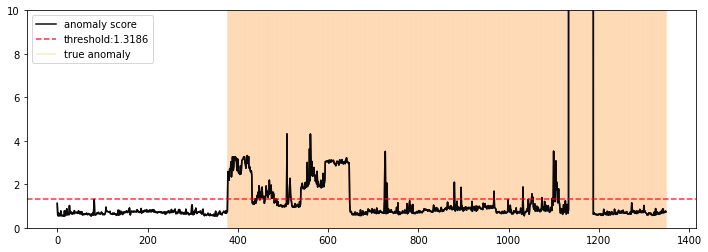

In [43]:
check_graph(scores, attack, threshold=threshold)
plt.ylim(0, 10)
plt.show()

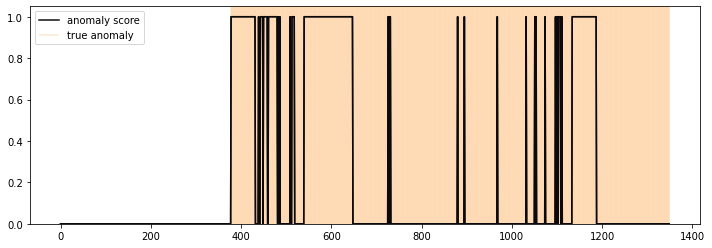

In [44]:
IF_pred = scores >= threshold
check_graph(IF_pred, attack)
plt.show()

In [46]:
bead_counter = []
pred_tf = [True if (i == 1.0) else False for i in IF_pred]
for i in range(len(pred_tf)//54):
    bead_counter.append(dict(Counter(pred_tf[i*54: (i+1)*54])))

print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {True: 54}, {False: 17, True: 37}, {True: 8, False: 46}, {True: 54}, {True: 54}, {False: 54}, {False: 50, True: 4}, {False: 54}, {False: 54}, {False: 52, True: 2}, {False: 53, True: 1}, {False: 54}, {False: 49, True: 5}, {False: 44, True: 10}, {True: 54}, {False: 54}, {False: 54}, {False: 54}]


# Cathode

In [41]:
with open('./data/Cathode_Train.pkl', 'rb') as f:
    Cathode_Train = pickle.load(f) 

In [42]:
with open('./data/Cathode_Test.pkl', 'rb') as f:
    Cathode_Test = pickle.load(f)

In [43]:
Cathode_Train

,LO,BR,NIR,VIS,label,dataset_idx,bead_num,identifier
59477,0.381503,0.009642,0.019061,-0.000435,0,20230330_134146_0__02_Total,0,Normal_20230330_134146_0__02_Total_0
59478,1.999758,0.002210,0.031365,-0.000435,0,20230330_134146_0__02_Total,0,Normal_20230330_134146_0__02_Total_0
59479,3.144621,0.276887,0.035575,0.000536,0,20230330_134146_0__02_Total,0,Normal_20230330_134146_0__02_Total_0
59480,3.683286,0.823011,0.038165,0.002802,0,20230330_134146_0__02_Total,0,Normal_20230330_134146_0__02_Total_0
59481,3.872642,1.509381,0.038489,0.005391,0,20230330_134146_0__02_Total,0,Normal_20230330_134146_0__02_Total_0
...,...,...,...,...,...,...,...,...
80296,4.039380,2.127244,0.097099,0.090834,0,74,53,Normal_74_53
80297,4.036148,2.092667,0.106490,0.095688,0,74,53,Normal_74_53
80298,4.020961,2.016727,0.109728,0.102485,0,74,53,Normal_74_53
80299,4.034856,2.005417,0.111023,0.108958,0,74,53,Normal_74_53


In [44]:
Cathode_Train.groupby(['identifier']).count()

,LO,BR,NIR,VIS,label,dataset_idx,bead_num
identifier,,,,,,,
Normal_20230330_134146_0__02_Total_0,100,100,100,100,100,100,100
Normal_20230330_134146_0__02_Total_1,100,100,100,100,100,100,100
Normal_20230330_134146_0__02_Total_10,100,100,100,100,100,100,100
Normal_20230330_134146_0__02_Total_11,100,100,100,100,100,100,100
Normal_20230330_134146_0__02_Total_12,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Normal_74_53,100,100,100,100,100,100,100
Normal_74_6,100,100,100,100,100,100,100
Normal_74_7,100,100,100,100,100,100,100


In [45]:
Cathode_Train.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [46]:
Cathode_Test.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [47]:
Cathode_Train['dataset_idx'].unique()

array(['20230330_134146_0__02_Total', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '58', '59', '61', '62', '63', '64', '65', '67',
       '68', '69', '70', '71', '72', '73', '74'], dtype=object)

In [48]:
Cathode_Train['identifier']

59477    Normal_20230330_134146_0__02_Total_0
59478    Normal_20230330_134146_0__02_Total_0
59479    Normal_20230330_134146_0__02_Total_0
59480    Normal_20230330_134146_0__02_Total_0
59481    Normal_20230330_134146_0__02_Total_0
                         ...                 
80296                            Normal_74_53
80297                            Normal_74_53
80298                            Normal_74_53
80299                            Normal_74_53
80300                            Normal_74_53
Name: identifier, Length: 134800, dtype: object

In [49]:
Cathode_Train_y = Cathode_Train['label'].astype(float)
Cathode_Train_X = Cathode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Cathode_Test_y = Cathode_Test['label'].astype(float)
Cathode_Test_X = Cathode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

In [50]:
Cathode_Train_X

,LO,BR,NIR,VIS
59477,0.381503,0.009642,0.019061,-0.000435
59478,1.999758,0.002210,0.031365,-0.000435
59479,3.144621,0.276887,0.035575,0.000536
59480,3.683286,0.823011,0.038165,0.002802
59481,3.872642,1.509381,0.038489,0.005391
...,...,...,...,...
80296,4.039380,2.127244,0.097099,0.090834
80297,4.036148,2.092667,0.106490,0.095688
80298,4.020961,2.016727,0.109728,0.102485
80299,4.034856,2.005417,0.111023,0.108958


In [51]:
import sys
sys.path.append("./TSAD")

In [52]:
from tsad.data import BuildDataset
from tsad.models import BeatGAN_MOCAP
from tsad.models import UsadModel
from tsad.metrics import bf_search, get_best_f1

In [53]:
window_size = 100
slide_size = 100 # USAD의 경우 value와 window가 대응이 되어야 하기 때문에 slide size = 1
model_type = 'reconstruction'
# valid_split_rate = 0.8
device = torch.device('cuda:{}'.format(0))

loader_params = {
    'batch_size': 32,
    'shuffle': False,
    'num_workers': 8,
    'pin_memory': False
}

In [54]:
scaler = MinMaxScaler()
Cathode_Train_X_scaled = pd.DataFrame(scaler.fit_transform(Cathode_Train_X))
Cathode_Test_X_scaled = pd.DataFrame(scaler.transform(Cathode_Test_X))

In [55]:
Cathode_Train_dataset = BuildDataset(Cathode_Train_X_scaled, Cathode_Train_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=None, model_type=model_type)

Cathode_Test_dataset = BuildDataset(Cathode_Test_X_scaled, Cathode_Test_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=np.array(Cathode_Test_y), model_type=model_type)

# of valid windows: 1348
# of valid windows: 1238


In [56]:
# w_size, z_size 정의

hidden_size = 100
# w_size = window_size*len(Cathode_Train_X_scaled[0]) # window size * feature 수
w_size = window_size*4 # window size * feature 수
z_size = window_size * hidden_size

In [57]:
import torch.utils.data as data_utils

Cathode_Train_dataloader = torch.utils.data.DataLoader(Cathode_Train_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)


Cathode_Test_dataloader = torch.utils.data.DataLoader(Cathode_Test_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

In [58]:
model = UsadModel(w_size, z_size)
model = UsadModel.to_device(model,device)

In [59]:
N_EPOCHS = 10
history = UsadModel.training(N_EPOCHS,model,Cathode_Train_dataloader, w_size)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [60]:
results=UsadModel.testing(model,Cathode_Test_dataloader,w_size)

In [61]:
tst_label = np.array(Cathode_Test_y)

In [62]:
windows_labels=[]
for i in range(0, len(tst_label), window_size):
    windows_labels.append(list(np.int_(tst_label[i:i+window_size])))

In [63]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [64]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])


In [65]:
len(y_pred), len(y_test)

(1238, 1238)

In [66]:
y_test = np.array(y_test)

In [67]:
dist = y_pred
attack = y_test
history = dict()

scores = dist.copy()

In [69]:
[f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bp_search(scores, attack,
                                                                            start=np.percentile(scores, 0),
                                                                            end=np.percentile(scores, 95),
                                                                            step_num=1000,
                                                                            K=100,
                                                                            verbose=False)

In [70]:
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')
print(f'threshold: {threshold}')

f1: 0.4664393686368987
precision: 0.9999999640287783
recall: 0.3041575459063726
roc_auc: 0.816023718831888
threshold: 0.01742709827329963


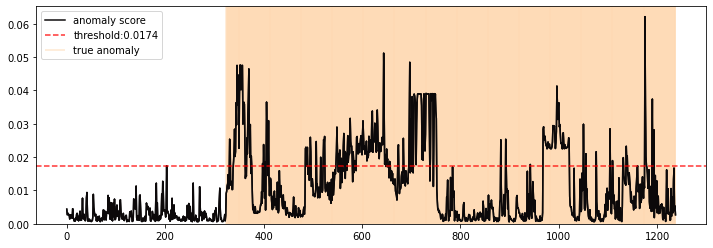

In [71]:
check_graph(scores, attack, threshold=threshold)
plt.show()

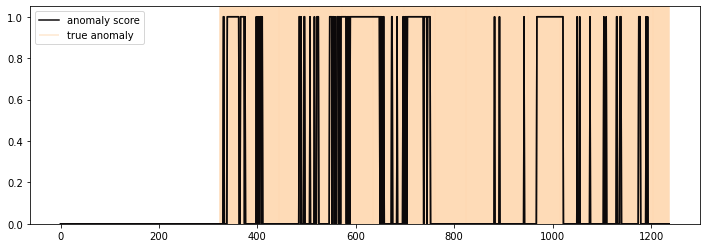

In [72]:
IF_pred = scores >= threshold
check_graph(IF_pred, attack)
plt.show()

In [73]:
bead_counter = []
pred_tf = [True if (i == 1.0) else False for i in IF_pred]
for i in range(len(pred_tf)//54):
    bead_counter.append(dict(Counter(pred_tf[i*54: (i+1)*54])))

print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 19, True: 35}, {False: 47, True: 7}, {False: 53, True: 1}, {True: 11, False: 43}, {False: 18, True: 36}, {True: 54}, {True: 14, False: 40}, {True: 47, False: 7}, {False: 54}, {False: 54}, {False: 52, True: 2}, {False: 49, True: 5}, {True: 50, False: 4}, {False: 51, True: 3}, {False: 50, True: 4}, {False: 47, True: 7}]


The End